In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import learning_curve,train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [36]:
data = pd.read_csv('./AppleStore.csv')

In [5]:
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
print(data.shape)
print(data.describe)

(7197, 17)
<bound method NDFrame.describe of       Unnamed: 0          id  \
0              1   281656475   
1              2   281796108   
2              3   281940292   
3              4   282614216   
4              5   282935706   
5              6   283619399   
6              7   283646709   
7              8   284035177   
8              9   284666222   
9             10   284736660   
10            11   284791396   
11            12   284815117   
12            13   284815942   
13            14   284847138   
14            15   284862767   
15            16   284876795   
16            17   284882215   
17            18   284910350   
18            20   284993459   
19            21   285005463   
20            22   285946052   
21            23   285994151   
22            24   286058814   
23            25   286070473   
24            27   286799607   
25            28   286906691   
26            29   286911400   
27            31   288113403   
28            32   28812039

In [37]:
r = (data['user_rating'] >= 4)
data['success'] = np.where(r, 1,0)
success = data['success'].value_counts()
print(success)

1    4781
0    2416
Name: success, dtype: int64


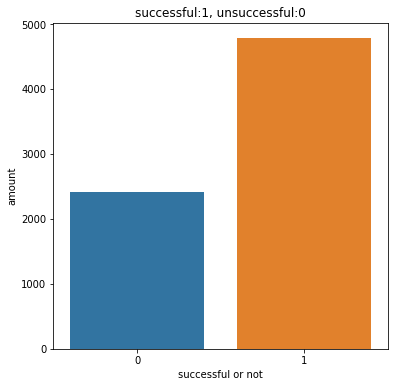

In [38]:
df = pd.DataFrame({'successful or not': success.index,'amount': success.values})
plt.figure(figsize = (6,6))
plt.title('successful:1, unsuccessful:0')
sns.set_color_codes("pastel")
sns.barplot(x = 'successful or not', y="amount", data=df)
locs, labels = plt.xticks()
plt.show()

#### define features and target

In [39]:
data.drop(['Unnamed: 0','id','track_name','currency','rating_count_ver','user_rating_ver','ver'],inplace=True,axis=1)

In [43]:
pg_mapping = {label:idx for idx,
                 label in enumerate(set(data['prime_genre']))}
data['prime_genre'] = data['prime_genre'].map(pg_mapping)

cr_mapping = {label:idx for idx,
                 label in enumerate(set(data['cont_rating']))}
data['cont_rating'] = data['cont_rating'].map(cr_mapping)

In [54]:
data.head()

,size_bytes,price,rating_count_tot,user_rating,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,success
0,100788224,3.99,21292,4.0,2,1,38,5,10,1,1
1,158578688,0.00,161065,4.0,2,21,37,5,23,1,1
2,100524032,0.00,188583,3.5,2,14,37,5,3,1,0
3,128512000,0.00,262241,4.0,3,2,37,5,9,1,1
4,92774400,0.00,985920,4.5,2,20,37,5,45,1,1


In [55]:
target=data['success'].values
columns = data.columns.tolist()
columns.remove('success')
features = data[columns].values

#### split train and test

In [58]:
train_x,test_x,train_y,test_y = train_test_split(features,target,test_size=0.3,stratify = target,random_state=1)

#### classifier

In [59]:
classifiers = [
    SVC(random_state=1,kernel='rbf'),
    DecisionTreeClassifier(random_state=1,criterion = 'gini'),
    RandomForestClassifier(random_state=1,criterion = 'gini'),
    KNeighborsClassifier(metric='minkowski'),
    AdaBoostClassifier(random_state=1),
]

classifier_names = [
    'svc',
    'decisiontreeclassifier',
    'randomforestclassifier',
    'kneighborsclassifier',
    'AdaB',
]

classifier_param_grid =[
    {'svc__C':[1],'svc__gamma':[0.01]},
    {'decisiontreeclassifier__max_depth':[6,9,11]},
    {'randomforestclassifier__n_estimators':[3,5,6]},
    {'kneighborsclassifier__n_neighbors':[4,6,8]},
    {'AdaB__n_estimators':[10,50,100]},
]

In [60]:
def gridsearchcv_work(pipeline,train_x,train_y,test_x,test_y,param_grid,score='accuracy'):
    response ={}
    gridsearch=GridSearchCV(estimator = pipeline,param_grid=param_grid,scoring=score)
    search = gridsearch.fit(train_x,train_y)
    print('the best parameter:',search.best_params_)
    print('the best score:',search.best_score_)
    predict_y = gridsearch.predict(test_x)
    print('accuracy:',accuracy_score(test_y,predict_y))
    response['predict_y']=predict_y
    response['accuracy_score']=accuracy_score(test_y,predict_y)
    return response

for model,model_name,model_param_grid in zip(classifiers,classifier_names,classifier_param_grid):
    pipeline=Pipeline(
    [('scaler',StandardScaler()),(model_name,model)]
    )
    result = gridsearchcv_work(pipeline,train_x,train_y,test_x,test_y,model_param_grid,score='accuracy')

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


the best parameter: {'svc__C': 1, 'svc__gamma': 0.01}
the best score: 0.9523525908278737
accuracy: 0.9800925925925926
the best parameter: {'decisiontreeclassifier__max_depth': 6}
the best score: 1.0
accuracy: 1.0


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


the best parameter: {'randomforestclassifier__n_estimators': 3}
the best score: 1.0
accuracy: 1.0


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


the best parameter: {'kneighborsclassifier__n_neighbors': 4}
the best score: 0.9346833432598769
accuracy: 0.9439814814814815
the best parameter: {'AdaB__n_estimators': 10}
the best score: 1.0
accuracy: 1.0


//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
